In [1]:
# face verification with the VGGFace2 model
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import hashlib
import cv2
import numpy as np
from face_detection.detect_face import inference as detect_face
    
model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
detector = MTCNN()
cache_crop_face = dict()
similarity_cache = dict()
THRESH = 0.5

Using TensorFlow backend.
2022-07-10 22:11:19.302714: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-07-10 22:11:19.319505: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc4a3ac2f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-10 22:11:19.319517: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [5]:



# extract a single face from a given photograph
def extract_face(pixels):
    
    # detect faces in the image
    st_time = time.time()
    results = detector.detect_faces(pixels)
    print("1. MTCNN Prediction time", time.time() - st_time)
    # extract the bounding box from the first face
    
    st_time = time.time()
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    print("2. Croping face time", time.time() - st_time)
    

    return face
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(image_hash_dict, required_size=(224, 224)):
    st_time = time.time()
    image_hashes = list(image_hash_dict.keys())
    
    # Caching cropped faces
    for img_hash, image in image_hash_dict.items():
        if img_hash not in cache_crop_face:
            face = detect_face(image)
            cache_crop_face[img_hash] = cv2.resize(face, dsize=required_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
            plt.imshow(cache_crop_face[img_hash])
            plt.show()
            print("Cropping Faces")
    
    # extract faces
    faces = [cache_crop_face[image_hashes[0]], cache_crop_face[image_hashes[1]]]  
    print("3. Get Faces time", time.time() - st_time)
    # convert into an array of samples
    st_time = time.time()
    # prepare the face for the model, e.g. center pixels
    print(faces[0].shape)
    print(faces[1].shape)
    samples = preprocess_input(faces, version=2)
    # perform prediction
    yhat = model.predict(samples)
    print("4. Similarity Prediction time", time.time() - st_time)
    return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
        return True, score, thresh
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
        return False, score, thresh
 


In [6]:
import time



def get_similarity(images: list([np.array, np.array])) -> list([int, str]):
    
    
    
    # Getting the image hashes
    image_hash_dict = { hashlib.md5(i.tobytes()).hexdigest() : i for i in images}
    image_hashes = list(image_hash_dict.keys())
    score, match = 1.0, True
    if len(image_hash_dict) > 1:

        # Checking if this image already in cache
        for image_hash in image_hashes:
            if image_hash in similarity_cache and search in similarity_cache[image_hash]:
                search = set(images) - set([image_hash])
                _, score = similarity_cache[image_hash].index(search)

        # If caches result not found
        st_time = time.time()
        embeddings = get_embeddings(image_hash_dict)
        print("\n\n Embedding time", time.time() - st_time)
        print('Positive Tests')

        # Comparing embedings
        st_time = time.time()
        score = cosine(embeddings[0], embeddings[1])
        match = score <= THRESH

        # Caching results
        if match: similarity_cache[image_hashes[0]] = [image_hashes[1], score]


    return [score, match]
        
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




 Image reading time 6.29425048828125e-05
priors nums:4420


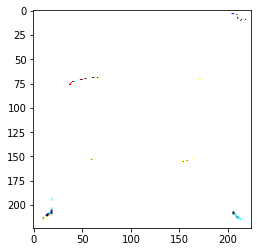

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cropping Faces
priors nums:4420


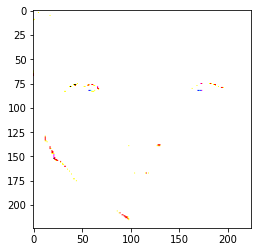

Cropping Faces
3. Get Faces time 0.2883579730987549
(224, 224, 3)
(224, 224, 3)
4. Similarity Prediction time 2.343116044998169


 Embedding time 2.6316168308258057
Positive Tests
0.7787326276302338 False


In [7]:
image_hash_dict = dict()
# define filenames
st_time = time.time()
filenames = ['/Users/sohaibanwar/Documents/face_recogination/testing_images/test3.jpeg', '/Users/sohaibanwar/Documents/face_recogination/testing_images/test2.jpeg']
print("\n\n Image reading time", time.time() - st_time)

# reading images and creating hash
images = [plt.imread(filename) for filename in filenames]
score , match = get_similarity(images)
print(score, match)

